In [82]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot12Dims_T256_H05_tl_110data_StbleTgt_WRMSE  import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [84]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


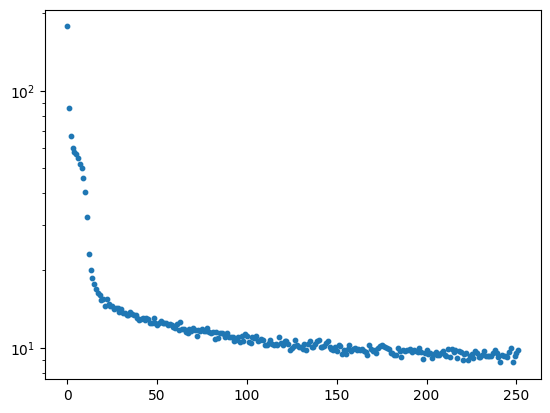

251

In [85]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

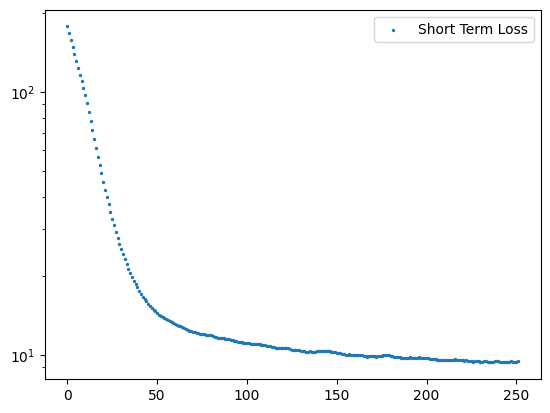

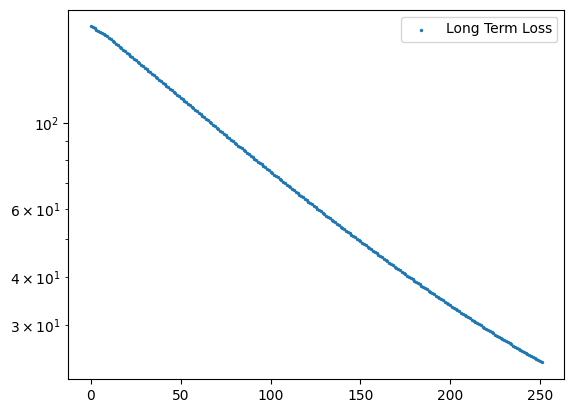

In [86]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

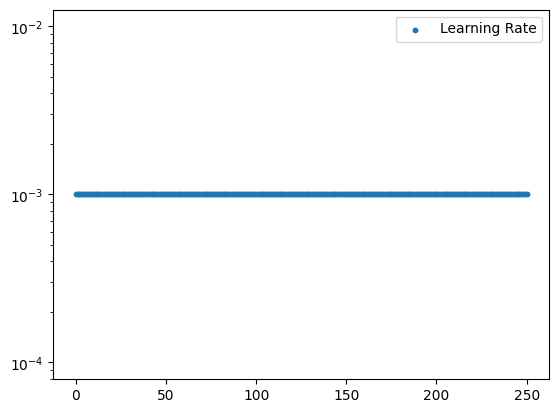

0


In [87]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [88]:
def get_drift_files(config):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims".replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "MLP" in file and ts_type in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "DriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [89]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config)
len(Nepochs_track)

124

In [90]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        #all_true_states = all_true_states.reshape(-1, config.ts_dims)
        #all_local_states = all_local_states.reshape(-1, config.ts_dims)
        #total_local_errors = [np.mean(np.sum(np.power(all_true_states-all_local_states, 2), axis=-1))]
        all_local_errors=np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

{2: 0.038213344361090945,
 4: 0.08452851630616007,
 6: 0.015217435063395365,
 8: 0.024840757053363572,
 10: 0.032620468097437766,
 12: 0.016979713674804706,
 14: 0.014685689140157896,
 16: 0.03810302667044884,
 18: 0.06678667203007893,
 20: 0.08831011916474359,
 22: 0.08441526328758017,
 24: 0.10213837161315151,
 26: 0.08983099351610623,
 28: 0.11605859525031344,
 30: 0.07416617601130124,
 32: 0.08973204721599576,
 34: 0.08371984687642386,
 36: 0.07197197779969768,
 38: 0.09379582332699217,
 40: 0.07557410124012542,
 42: 0.06787677294055064,
 44: 0.07766496174479277,
 46: 0.08449938937639992,
 48: 0.07162977535421039,
 50: 0.06885865485013568,
 52: 0.07165591880763522,
 54: 0.07287279357398434,
 56: 0.06701810567789249,
 58: 0.06514284354412894,
 60: 0.06093233938954484,
 62: 0.06748585478995481,
 64: 0.06535163843051835,
 66: 0.07311062193884542,
 68: 0.06738339352461896,
 70: 0.06687705303748331,
 72: 0.06310000913469571,
 74: 0.06545876250585972,
 76: 0.06156310320143514,
 78: 0.065

In [91]:
toSave = False
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [92]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
print(Nepochs_losses)
common_epochs = np.intersect1d(common_epochs, np.arange(0, 4600))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
print(common_epochs)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

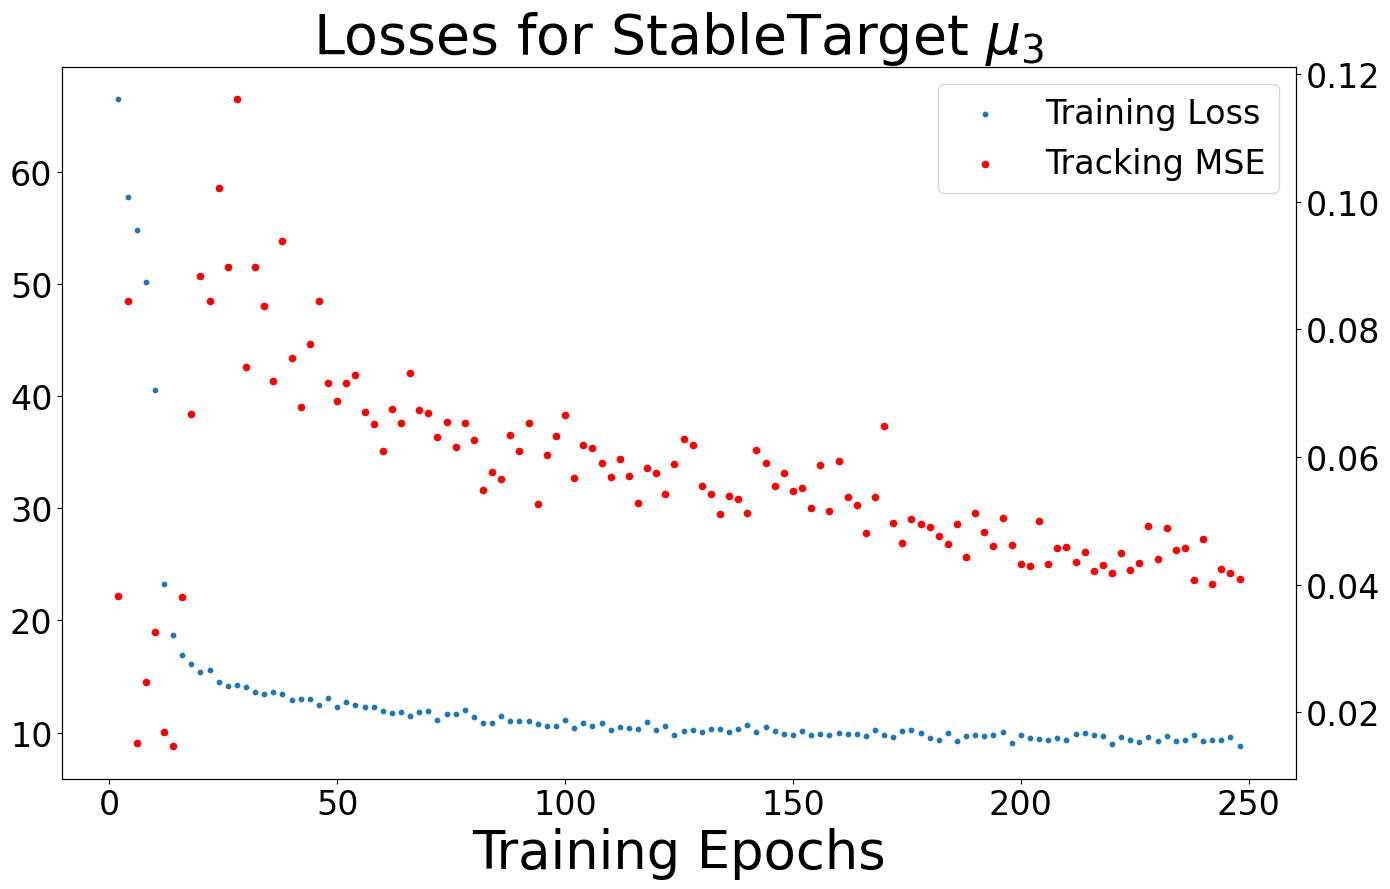

In [93]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)

elif "SinLog" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{1}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{2}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{4}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "_ST_" in config.scoreNet_trained_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    else:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

(20, 100, 101, 12)
(10, 100, 257, 12)


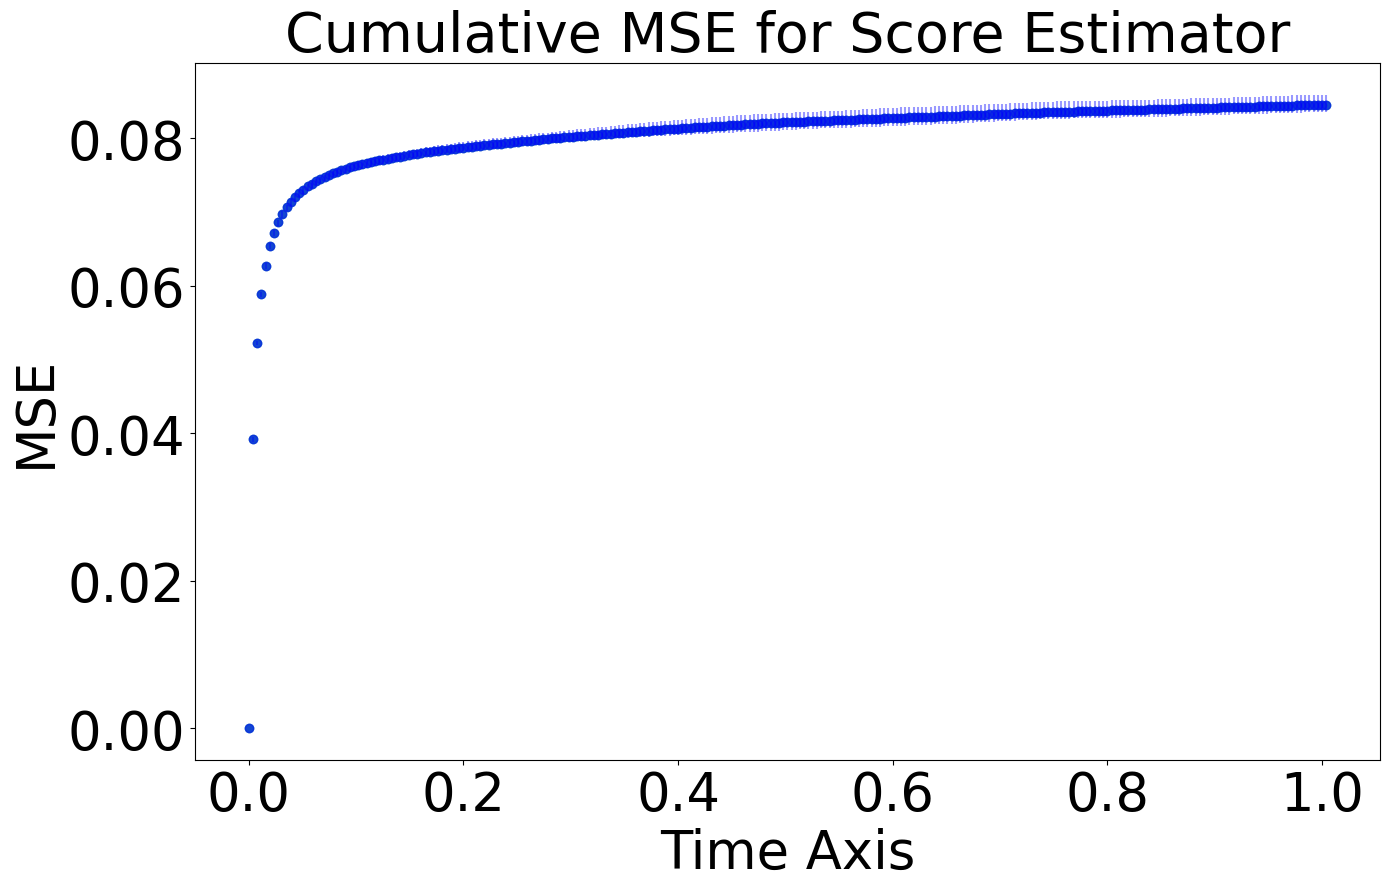

Final time cumulative MSE local-time error 0.08452851630616007 with final IQR (0.0835744005240818, 0.08589694734700731) at Nepoch 4

(10, 100, 257, 12)


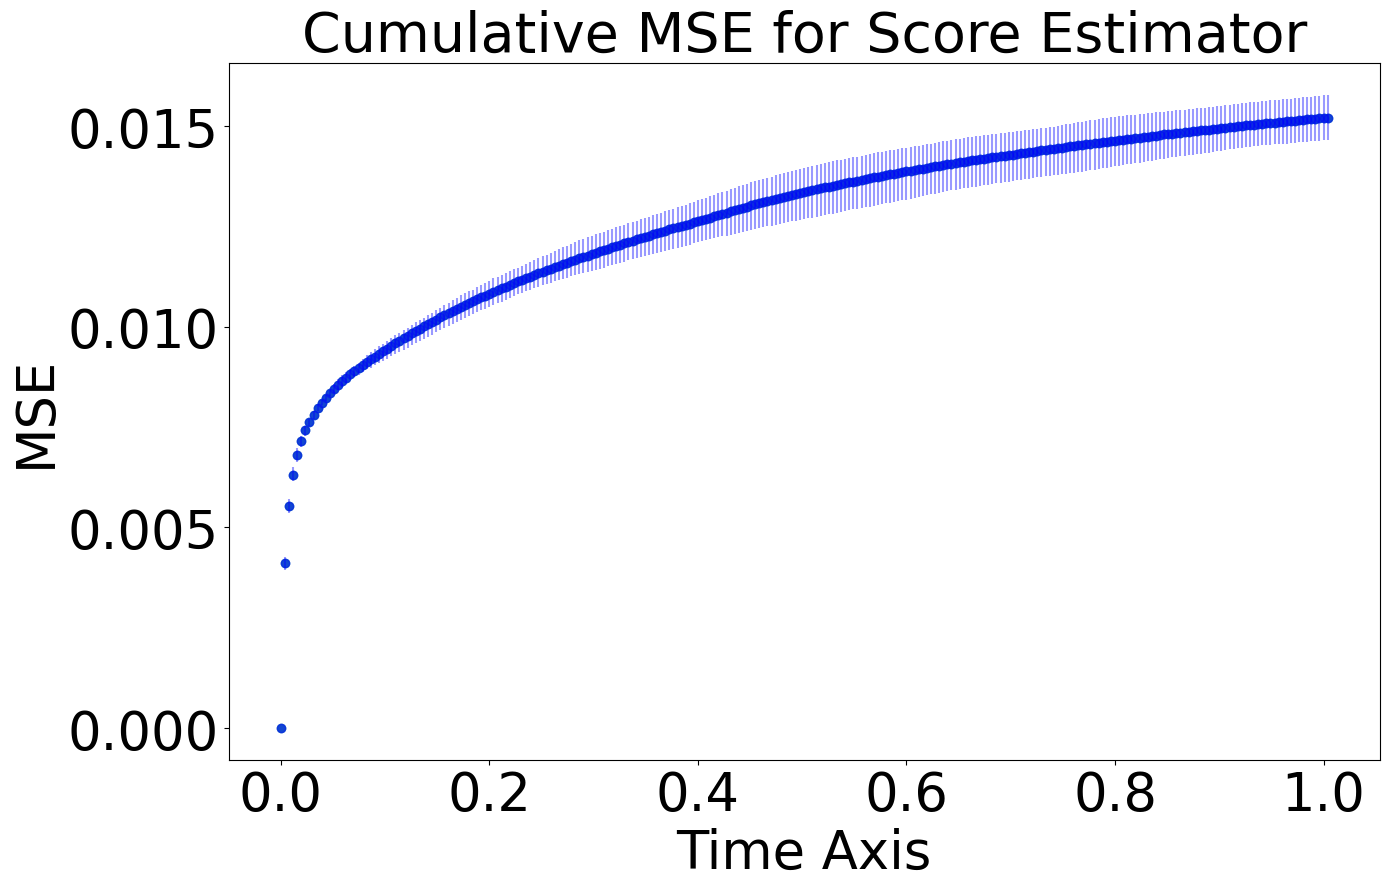

Final time cumulative MSE local-time error 0.015217435063395365 with final IQR (0.014652257889416835, 0.015787487174747417) at Nepoch 6

(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)


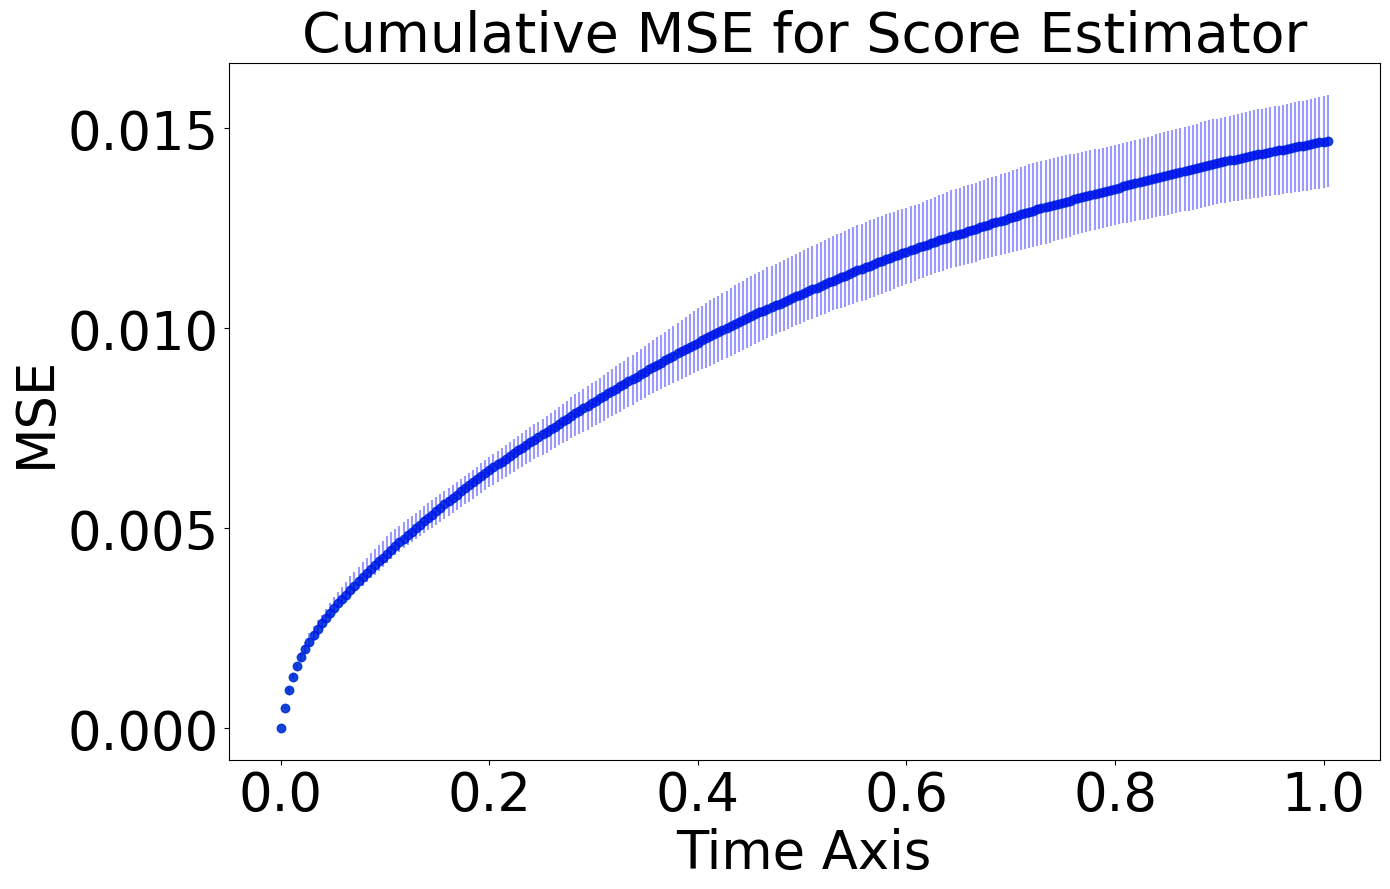

Final time cumulative MSE local-time error 0.014685689140157896 with final IQR (0.013517752812880651, 0.015839014411494885) at Nepoch 14

(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 100, 257, 12)
(10, 10

In [94]:
curr_rmse = np.inf
toSave = False
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        num_diff_times = 1
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        print(all_local_states.shape)
        if all_local_states.shape[2] != 257: raise FileNotFoundError
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(all_local_errors, axis=0)
        total_local_errors_minq = np.quantile(all_local_errors, axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(all_local_errors, axis=0,q=0.975)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative MSE for Score Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fBiPot_{config.ndims}DDims_OOSDriftTrack_{Nepoch}Nep_PM_MLP").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue

In [95]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
import torch
scoreModel1 = ConditionalMarkovianTSPostMeanScoreMatching(
        *config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/"
modelname = config.scoreNet_trained_path.replace(rootdir, "")
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel1.load_state_dict(torch.load(rootdir+file))
scoreModel1.eval()
scoreModel2 = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/snapshots/"
final_epoch = Nepochs_losses[-1]
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel2.load_state_dict(torch.load(rootdir+file, map_location=torch.device("cpu"))["MODEL_STATE"])
scoreModel2.eval()

ConditionalMarkovianTSPostMeanScoreMatching(
  (input_projection): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (diffusion_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=128, out_features=64, bias=True)
    (projection2): Linear(in_features=64, out_features=64, bias=True)
  )
  (mlp_state_mapper): MLPStateMapper(
    (hybrid): HybridStates()
    (preprocess): Sequential(
      (0): Linear(in_features=12, out_features=4, bias=True)
      (1): ELU(alpha=1.0)
    )
    (linear2): Linear(in_features=48, out_features=4, bias=True)
    (linear3): Linear(in_features=4, out_features=20, bias=True)
  )
  (cond_upsampler): CondUpsampler(
    (linear1): Linear(in_features=20, out_features=20, bias=False)
    (linear2): Linear(in_features=20, out_features=24, bias=False)
    (linear3): Linear(in_features=24, out_features=12, bias=False)
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,

In [96]:

torch.mean(torch.exp(scoreModel1.mlp_state_mapper.hybrid.log_scale)), torch.mean(torch.sigmoid(scoreModel1.mlp_state_mapper.hybrid.gate_logits / 0.5)), scoreModel1.mlp_state_mapper.hybrid.tau

(tensor(43.7219, grad_fn=<MeanBackward0>),
 tensor(0.4318, grad_fn=<MeanBackward0>),
 1.0)

In [97]:
torch.mean(torch.exp(scoreModel2.mlp_state_mapper.hybrid.log_scale)), torch.mean(torch.sigmoid(scoreModel2.mlp_state_mapper.hybrid.gate_logits / 0.5)), scoreModel2.mlp_state_mapper.hybrid.tau

(tensor(43.4468, grad_fn=<MeanBackward0>),
 tensor(0.4307, grad_fn=<MeanBackward0>),
 1.0)